In [59]:
import numpy as np
import pandas as pd
import vectorbtpro as vbt

In [60]:
## Load m1 data
m1_data = vbt.HDFData.fetch('../../data/GU_OHLCV_3Y.h5')
m1_data.wrapper.index #pandas doaesn't recognise the frequency because of missing timestamps

DatetimeIndex(['2019-08-27 00:00:00+00:00', '2019-08-27 00:01:00+00:00',
               '2019-08-27 00:02:00+00:00', '2019-08-27 00:03:00+00:00',
               '2019-08-27 00:04:00+00:00', '2019-08-27 00:05:00+00:00',
               '2019-08-27 00:06:00+00:00', '2019-08-27 00:07:00+00:00',
               '2019-08-27 00:08:00+00:00', '2019-08-27 00:09:00+00:00',
               ...
               '2022-08-26 16:50:00+00:00', '2022-08-26 16:51:00+00:00',
               '2022-08-26 16:52:00+00:00', '2022-08-26 16:53:00+00:00',
               '2022-08-26 16:54:00+00:00', '2022-08-26 16:55:00+00:00',
               '2022-08-26 16:56:00+00:00', '2022-08-26 16:57:00+00:00',
               '2022-08-26 16:58:00+00:00', '2022-08-26 16:59:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=1122468, freq=None)

In [61]:
m5_data  = m1_data.resample('5T')   # Convert 1 minute to 5 mins
m15_data = m1_data.resample('15T')  # Convert 1 minute to 15 mins
m30_data = m1_data.resample('30T')  # Convert 1 minute to 30 mins
h1_data = m1_data.resample("1h")    # Convert 1 minute to 1 hour
h4_data = m1_data.resample("4h")    # Convert 1 minute to 4 hour
d1_data = m1_data.resample("1d")    # Convert 1 minute to daily

In [62]:
# Obtain all the closing  prices using the .get() method
m5_close = m5_data.get()['Close']
m15_close = m15_data.get()['Close']

##m30 data
m30_open  = m30_data.get()['Open']
m30_close = m30_data.get()['Close']
m30_high  = m30_data.get()['High']
m30_low   = m30_data.get()['Low']

## h1 data
h1_open  = h1_data.get()['Open']
h1_close = h1_data.get()['Close']
h1_high  = h1_data.get()['High']
h1_low   = h1_data.get()['Low']

## h4 data
h4_open  = h4_data.get()['Open']
h4_close = h4_data.get()['Close']
h4_high  = h4_data.get()['High']
h4_low   = h4_data.get()['Low']

## 1D data
d1_open  = d1_data.get()['Open']
d1_close = d1_data.get()['Close']
d1_high  = d1_data.get()['High']
d1_low   = d1_data.get()['Low']

### Creating the Indicators for multi-timeframes

In [63]:
## Method 1 - Manual of method of MTF Indicator creation
rsi_period = 21

## 5m indicators
m5_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(m5_data.get("Close"), skipna=True).real
m5_bbands = vbt.talib("BBANDS").run(m5_data.get("Close"), skipna=True)
m5_bbands_rsi = vbt.talib("BBANDS").run(m5_rsi, skipna=True)

## 15m indicators
m15_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(m15_data.get("Close"), skipna=True).real
m15_bbands = vbt.talib("BBANDS").run(m15_data.get("Close"), skipna=True)
m15_bbands_rsi = vbt.talib("BBANDS").run(m15_rsi, skipna=True)

## 30m indicators
m30_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(m30_data.get("Close"), skipna=True).real
m30_bbands = vbt.talib("BBANDS").run(m30_data.get("Close"), skipna=True)
m30_bbands_rsi = vbt.talib("BBANDS").run(m30_rsi, skipna=True)

## h1 indicators
h1_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(h1_data.get("Close"), skipna=True).real
h1_bbands = vbt.talib("BBANDS").run(h1_data.get("Close"), skipna=True)
h1_bbands_rsi = vbt.talib("BBANDS").run(h1_rsi, skipna=True)

## h4 indicators
h4_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(h4_data.get("Close"), skipna=True).real
h4_bbands = vbt.talib("BBANDS").run(h4_data.get("Close"), skipna=True)
h4_bbands_rsi = vbt.talib("BBANDS").run(h4_rsi, skipna=True)

### Resample and creating a multi-time frame dataframe

Upsampling higher timeframe (`low frequency`) data to lower timeframe (`high frequency`) data

In [64]:
def create_resamplers(result_dict_keys_list : list, source_indices : list,  source_frequencies :list, target_index : pd.Series, target_freq : str):
    """
    Creates a dictionary of vbtpro resampler objects.

    Parameters
    ==========
    result_dict_keys_list : list, list of strings, which are keys of the output dictionary
    source_indices        : list, list of pd.time series objects of the higher timeframes
    source_frequencies    : list, list of strings, which are short form representation of the time series order. Eg:["1D", "4h"]
    target_index          : pd.Series, target time series for the resampler objects
    target_freq           : str, target time frequency for the resampler objects,
                            use the 1st frequency in source_frequencies list

    Returns
    ===========
    resamplers_dict       : dict, vbt pro resampler objects
    """
    
    
    resamplers = []
    for si, sf in zip(source_indices, source_frequencies):
        resamplers.append(vbt.Resampler(source_index = si,  target_index = target_index,  source_freq = sf, target_freq = target_freq))
    return dict(zip(result_dict_keys_list, resamplers))

In [65]:
## Create Resampler Objects for upsampling
src_indices = [m15_close.index, m30_close.index, h1_close.index, h4_close.index, d1_close.index ]
src_frequencies = ["15T","30T", "1h", "4h"] #, "1D"
resampler_dict_keys = ["m15_m5", "m30_m5", "h1_m5", "h4_m5"] # "d1_m5"

# list_resamplers = create_resamplers(resampler_dict_keys, src_indices, src_frequencies, m5_close.index, "5T")
list_resamplers = create_resamplers(resampler_dict_keys, src_indices, src_frequencies, m15_close.index, "15T")

list_resamplers

{'m15_m5': <vectorbtpro.base.resampling.base.Resampler at 0x28a52c9a0>,
 'm30_m5': <vectorbtpro.base.resampling.base.Resampler at 0x28a52e2f0>,
 'h1_m5': <vectorbtpro.base.resampling.base.Resampler at 0x28a52f430>,
 'h4_m5': <vectorbtpro.base.resampling.base.Resampler at 0x28a52f0a0>}

### Notes:
Setting the target index and targex frequency to 5min, creates more NULL values in the resampling of higher time frame data, which in turn creates a difference in the total nr. of orders ( `Total Trades` ) and ultimately the `Total Return [%]`

In [66]:
## Initialize  dictionary
data = {}

# data = {"m5_close" : m5_close.ffill(), "m5_rsi" : m5_rsi.ffill(), 
#         "m5_bband_price_upper" : m5_bbands.upperband.ffill(),  "m5_bband_price_middle" : m5_bbands.middleband.ffill(),  "m5_bband_price_lower" : m5_bbands.lowerband.ffill(),
#         "m5_bband_rsi_upper" : m5_bbands_rsi.upperband.ffill(),  "m5_bband_rsi_middle" : m5_bbands_rsi.middleband.ffill(), "m5_bband_rsi_lower" : m5_bbands_rsi.lowerband.ffill() 
#         }

In [67]:
## Use along with method 1 - Manual indicator creation for MTF
series_to_resample = [
    [m15_close, m15_rsi, m15_bbands.upperband, m15_bbands.middleband, m15_bbands.lowerband, m15_bbands_rsi.upperband, m15_bbands_rsi.middleband, m15_bbands_rsi.lowerband],
    [m30_close, m30_rsi, m30_bbands.upperband, m30_bbands.middleband, m30_bbands.lowerband, m30_bbands_rsi.upperband, m30_bbands_rsi.middleband, m30_bbands_rsi.lowerband],
    [h1_close, h1_rsi, h1_bbands.upperband, h1_bbands.middleband, h1_bbands.lowerband, h1_bbands_rsi.upperband, h1_bbands_rsi.middleband, h1_bbands_rsi.lowerband],
    [h4_close, h4_rsi, h4_bbands.upperband, h4_bbands.middleband, h4_bbands.lowerband, h4_bbands_rsi.upperband, h4_bbands_rsi.middleband, h4_bbands_rsi.lowerband],
    # [d1_close, d1_rsi, d1_bbands.upperband, d1_bbands.middleband, d1_bbands.lowerband, d1_bbands_rsi.upperband, d1_bbands_rsi.middleband, d1_bbands_rsi.lowerband]
    ]

data_keys = [
    ["m15_close", "m15_rsi", "m15_bband_price_upper",  "m15_bband_price_middle", "m15_bband_price_lower",  "m15_bband_rsi_upper",  "m15_bband_rsi_middle", "m15_bband_rsi_lower"], 
    ["m30_close", "m30_rsi", "m30_bband_price_upper",  "m30_bband_price_middle", "m30_bband_price_lower",  "m30_bband_rsi_upper",  "m30_bband_rsi_middle", "m30_bband_rsi_lower"],
    ["h1_close", "h1_rsi", "h1_bband_price_upper",  "h1_bband_price_middle",  "h1_bband_price_lower",  "h1_bband_rsi_upper",  "h1_bband_rsi_middle", "h1_bband_rsi_lower" ],
    ["h4_close", "h4_rsi", "h4_bband_price_upper",  "h4_bband_price_middle",  "h4_bband_price_lower",  "h4_bband_rsi_upper",  "h4_bband_rsi_middle", "h4_bband_rsi_lower" ],
    # ["d1_close", "d1_rsi", "d1_bband_price_upper",  "d1_bband_price_middle",  "d1_bband_price_lower",  "d1_bband_rsi_upper",  "d1_bband_rsi_middle", "d1_bband_rsi_lower" ]
         ]

In [68]:
## Use this along with Method 1 of indicator creation

for lst_series, lst_keys, resampler in zip(series_to_resample, data_keys, resampler_dict_keys):
    for key, time_series in zip(lst_keys, lst_series):
        resampled_time_series = time_series.vbt.resample_closing(list_resamplers[resampler])
        data[key] = resampled_time_series.ffill()
        # print('BEFORE RESAMPLING - ', key, time_series.index.freq, 'length:' ,len(time_series), 'NULL Count:',time_series.isna().sum())
        # print("AFTER RESAMPLING - ",resampled_time_series.index.freq, 'length:' ,len(resampled_time_series), 'NULL Count:',resampled_time_series.isna().sum(), '\n' )

In [69]:
## Add m30 OLH data
# data["m30_open"] = m30_open.vbt.resample_opening(list_resamplers['m30_m5']).ffill()
# data["m30_high"] = m30_high.vbt.resample_closing(list_resamplers['m30_m5']).ffill()
# data["m30_low"]  = m30_low.vbt.resample_closing(list_resamplers['m30_m5']).ffill()

## Add h1 OLH data
data["h1_open"] = h1_open.vbt.resample_opening(list_resamplers['h1_m5']).ffill()
data["h1_high"] = h1_high.vbt.resample_closing(list_resamplers['h1_m5']).ffill()
data["h1_low"]  = h1_low.vbt.resample_closing(list_resamplers['h1_m5']).ffill()

## Add h4 OLH data
data["h4_open"] = h4_open.vbt.resample_opening(list_resamplers['h4_m5']).ffill()
data["h4_high"] = h4_high.vbt.resample_closing(list_resamplers['h4_m5']).ffill()
data["h4_low"]  = h4_low.vbt.resample_closing(list_resamplers['h4_m5']).ffill()

Constructing DataFrame of Multi-Time Frame Data

In [70]:
cols_order = [
    # 'm5_close','m5_rsi','m5_bband_price_upper','m5_bband_price_middle','m5_bband_price_lower','m5_bband_rsi_upper','m5_bband_rsi_middle','m5_bband_rsi_lower',
'm15_close','m15_rsi','m15_bband_price_upper','m15_bband_price_middle', 'm15_bband_price_lower','m15_bband_rsi_upper','m15_bband_rsi_middle', 'm15_bband_rsi_lower',
'm30_close','m30_rsi', 'm30_bband_price_upper', 'm30_bband_price_middle', 'm30_bband_price_lower', 'm30_bband_rsi_upper', 'm30_bband_rsi_middle', 'm30_bband_rsi_lower',
 'h1_open', 'h1_high', 'h1_low', 'h1_close', 'h1_rsi', 'h1_bband_price_upper', 'h1_bband_price_middle', 'h1_bband_price_lower', 'h1_bband_rsi_upper', 'h1_bband_rsi_middle','h1_bband_rsi_lower',
 'h4_open', 'h4_high', 'h4_low', 'h4_close', 'h4_rsi', 'h4_bband_price_upper', 'h4_bband_price_middle', 'h4_bband_price_lower', 'h4_bband_rsi_upper', 'h4_bband_rsi_middle', 'h4_bband_rsi_lower'
 ]

In [71]:
## construct a multi-timeframe dataframe
mtf_df = pd.DataFrame(data)[cols_order]
print("Length of mtf_df:",len(mtf_df), f'on {mtf_df.index.freq} frequency')

Length of mtf_df: 105188 on <15 * Minutes> frequency


In [72]:
for col in mtf_df.columns:
    time_series = mtf_df[col]
    print(col,time_series.index.freq, 'length:' ,len(time_series), 'NULL Count:',time_series.isna().sum())

m15_close <15 * Minutes> length: 105188 NULL Count: 0
m15_rsi <15 * Minutes> length: 105188 NULL Count: 21
m15_bband_price_upper <15 * Minutes> length: 105188 NULL Count: 4
m15_bband_price_middle <15 * Minutes> length: 105188 NULL Count: 4
m15_bband_price_lower <15 * Minutes> length: 105188 NULL Count: 4
m15_bband_rsi_upper <15 * Minutes> length: 105188 NULL Count: 25
m15_bband_rsi_middle <15 * Minutes> length: 105188 NULL Count: 25
m15_bband_rsi_lower <15 * Minutes> length: 105188 NULL Count: 25
m30_close <15 * Minutes> length: 105188 NULL Count: 1
m30_rsi <15 * Minutes> length: 105188 NULL Count: 43
m30_bband_price_upper <15 * Minutes> length: 105188 NULL Count: 9
m30_bband_price_middle <15 * Minutes> length: 105188 NULL Count: 9
m30_bband_price_lower <15 * Minutes> length: 105188 NULL Count: 9
m30_bband_rsi_upper <15 * Minutes> length: 105188 NULL Count: 51
m30_bband_rsi_middle <15 * Minutes> length: 105188 NULL Count: 51
m30_bband_rsi_lower <15 * Minutes> length: 105188 NULL Count:

In [73]:
display(mtf_df)

,m15_close,m15_rsi,m15_bband_price_upper,m15_bband_price_middle,m15_bband_price_lower,m15_bband_rsi_upper,m15_bband_rsi_middle,m15_bband_rsi_lower,m30_close,m30_rsi,...,h4_high,h4_low,h4_close,h4_rsi,h4_bband_price_upper,h4_bband_price_middle,h4_bband_price_lower,h4_bband_rsi_upper,h4_bband_rsi_middle,h4_bband_rsi_lower
time,,,,,,,,,,,,,,,,,,,,,
2019-08-27 00:00:00+00:00,1.221165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:15:00+00:00,1.221705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221705,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:30:00+00:00,1.221790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221705,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:45:00+00:00,1.221735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221735,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 01:00:00+00:00,1.221890,NaN,1.222165,1.221657,1.221149,NaN,NaN,NaN,1.221735,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-26 15:45:00+00:00,1.173765,32.831305,1.174692,1.174085,1.173478,34.856820,33.463077,32.069334,1.173765,32.952819,...,1.17836,1.17354,1.173765,38.014083,1.185437,1.17896,1.172483,47.617494,42.127199,36.636905
2022-08-26 16:00:00+00:00,1.173510,32.175416,1.174568,1.173909,1.173250,34.593092,33.073149,31.553206,1.173765,32.952819,...,1.17836,1.17354,1.173765,38.014083,1.185437,1.17896,1.172483,47.617494,42.127199,36.636905
2022-08-26 16:15:00+00:00,1.174110,35.365534,1.174339,1.173847,1.173355,35.571314,33.293702,31.016089,1.174110,34.276540,...,1.17836,1.17354,1.173765,38.014083,1.185437,1.17896,1.172483,47.617494,42.127199,36.636905


In [74]:
# print(mtf_df.columns.to_list())

In [75]:
mtf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105188 entries, 2019-08-27 00:00:00+00:00 to 2022-08-26 16:45:00+00:00
Freq: 15T
Data columns (total 38 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   m15_close               105188 non-null  float64
 1   m15_rsi                 105167 non-null  float64
 2   m15_bband_price_upper   105184 non-null  float64
 3   m15_bband_price_middle  105184 non-null  float64
 4   m15_bband_price_lower   105184 non-null  float64
 5   m15_bband_rsi_upper     105163 non-null  float64
 6   m15_bband_rsi_middle    105163 non-null  float64
 7   m15_bband_rsi_lower     105163 non-null  float64
 8   m30_close               105187 non-null  float64
 9   m30_rsi                 105145 non-null  float64
 10  m30_bband_price_upper   105179 non-null  float64
 11  m30_bband_price_middle  105179 non-null  float64
 12  m30_bband_price_lower   105179 non-null  float64
 13  m30_bband_rsi_uppe

### Double Bollinger Band - Strategy Conditions
The trading conditions (rules) of the strategy are as follows:

1. A long (buy) signal is generated whenever the H4 market (Low) price surpasses its lower Bollinger band after having been below it while simultaneously, the 5m RSI surpasses its lower Bollinger band after having been below it.

2. A short (sell) signal is generated whenever the H4 market (High) price breaks its upper Bollinger band after having been above it while simultaneously, the 5m RSI breaks below its upper Bollinger band after having been above it.

In [76]:
required_cols = [
                # 'm5_close', "m5_rsi" , "m5_bband_rsi_lower", "m5_bband_rsi_upper" ,
                'm15_close','m15_rsi','m15_bband_rsi_lower', 'm15_bband_rsi_upper',
                #  "h1_low", "h1_rsi" , "h1_bband_price_lower" ,
                 'h4_low', "h4_rsi", "h4_bband_price_lower", "h4_bband_price_upper"]

In [77]:
mtf_df[required_cols][(mtf_df['h4_low'] < mtf_df['h4_bband_price_lower'])]

,m15_close,m15_rsi,m15_bband_rsi_lower,m15_bband_rsi_upper,h4_low,h4_rsi,h4_bband_price_lower,h4_bband_price_upper
time,,,,,,,,
2019-08-28 07:45:00+00:00,1.221015,40.233071,36.371864,44.167140,1.21560,NaN,1.220568,1.231622
2019-08-28 08:00:00+00:00,1.220345,38.542404,36.437396,44.147542,1.21560,NaN,1.220568,1.231622
2019-08-28 08:15:00+00:00,1.220470,39.044185,37.188728,43.869228,1.21560,NaN,1.220568,1.231622
2019-08-28 08:30:00+00:00,1.220750,40.192684,37.131808,43.259400,1.21560,NaN,1.220568,1.231622
2019-08-28 08:45:00+00:00,1.220950,41.026053,38.019391,41.595967,1.21560,NaN,1.220568,1.231622
...,...,...,...,...,...,...,...,...
2022-08-26 14:30:00+00:00,1.174670,34.772576,34.241673,36.846966,1.17539,41.062856,1.176465,1.184877
2022-08-26 14:45:00+00:00,1.174390,34.125056,33.534063,36.883666,1.17539,41.062856,1.176465,1.184877
2022-08-26 15:00:00+00:00,1.174420,34.262770,33.733499,35.736596,1.17539,41.062856,1.176465,1.184877


In [78]:
## Higher values greater than 1.0 are like moving up the lower RSI b-band, signifying if the lowerband rsi is anywhere around 1% of the lower b-band validate that case as True
bb_upper_fract = 0.99
bb_lower_fract = 1.01

In [79]:
# mtf_df[required_cols][(mtf_df['m5_rsi'] < (bb_lower_fract * mtf_df['m5_bband_rsi_lower']) )]

In [80]:
## When additional checking if RSI goes below 30 it Yields very few results
# mtf_df[required_cols][(mtf_df['m5_rsi'] < (bb_lower_fract * mtf_df['m5_bband_rsi_lower']) ) & (mtf_df['m5_rsi'] <= 30)]

In [81]:
## Long Entry Conditions
c1_long_entry = (mtf_df['h4_low'] <= mtf_df['h4_bband_price_lower'])
c2_long_entry = (mtf_df['m15_rsi'] <= (bb_lower_fract * mtf_df['m15_bband_rsi_lower']) )
# c3_long_entry = (mtf_df['m5_rsi'] <= 30)
# c4_long_entry = (mtf_df['m5_rsi'] <= (bb_lower_fract * mtf_df['m5_bband_rsi_lower']) )

## Long Exit Conditions
c1_long_exit =  (mtf_df['h4_high'] >= mtf_df['h4_bband_price_upper'])
c2_long_exit = (mtf_df['m15_rsi'] >= (bb_upper_fract * mtf_df['m15_bband_rsi_upper'])) 
# c3_long_exit = (mtf_df['m5_rsi'] >= 70)
# c4_long_exit = (mtf_df['m5_rsi'] >= (bb_upper_fract * mtf_df['m5_bband_rsi_upper']))

In [82]:
## Strategy conditions check - Using m15 and h4 data 
mtf_df['entry'] = c1_long_entry & c2_long_entry
mtf_df['exit']  = c1_long_exit & c2_long_exit

In [83]:
## Strategy conditions check - Using m5, m15 and h4 data 
# mtf_df['entry'] = c1_long_entry & c2_long_entry & c3_long_entry
# mtf_df['exit']  = c1_long_exit & c2_long_exit & c3_long_exit

In [84]:
## Strategy conditions check - Using m5 (2 conditions) and h4 data 
# mtf_df['entry'] = c1_long_entry & c3_long_entry & c4_long_entry
# mtf_df['exit']  = c1_long_exit & c3_long_exit & c4_long_exit

In [85]:
## Final conditions - Using m5 (1 condition) and h4 data 
# mtf_df['entry'] = c1_long_entry & c4_long_entry
# mtf_df['exit']  = c1_long_exit & c4_long_exit

In [86]:
mtf_df['signal'] = 0   
mtf_df['signal'] = np.where( mtf_df['entry'] ,1, 0)
mtf_df['signal'] = np.where( mtf_df['exit'] ,-1, mtf_df['signal'])

In [87]:
entries = mtf_df.signal == 1.0
exits = mtf_df.signal == -1.0

# mtf_df['short_entries'] = short_entries = long_exits
# mtf_df['short_exits'] = short_exits = long_entries

# mtf_df.drop(columns="signal", axis=1, inplace = True)
# mtf_df.head()

_Cleaning_ `entries` and `exit` signals by removing redundant signals

In [88]:
print(entries.vbt.signals.total(), exits.vbt.signals.total())
print(len(entries), len(exits))

692 839
105188 105188


In [89]:
## Clean redundant and duplicate signals
clean_entries, clean_exits = entries.vbt.signals.clean(exits)

In [90]:
print(entries.vbt.signals.total(),exits.vbt.signals.total())
print(len(clean_entries), len(clean_exits))

692 839
105188 105188


Resampling `entries` and `exits` to `H4` for plotting purpose

In [91]:
%%time
## Faster method
h4_entries = entries.vbt.resample_apply("4h", "any", wrap_kwargs=dict(dtype=bool))
h4_exits = exits.vbt.resample_apply("4h", "any", wrap_kwargs=dict(dtype=bool))

CPU times: user 7.75 ms, sys: 949 µs, total: 8.7 ms
Wall time: 7.76 ms


In [92]:
print(len(h4_entries),len(h4_exits))
print(h4_entries.vbt.signals.total(),h4_exits.vbt.signals.total())

6575 6575
476 528


In [93]:
clean_h4_entries, clean_h4_exits = h4_entries.vbt.signals.clean(h4_exits)

In [94]:
print(len(clean_h4_entries),len(clean_h4_exits))
print(clean_h4_entries.vbt.signals.total(),clean_h4_exits.vbt.signals.total())

6575 6575
210 210


### Plotting Indicators

In [95]:
## Global Plot Settings
vbt.settings.set_theme("dark")
vbt.settings['plotting']['layout']['width'] = 1280

In [96]:
## Acquire Data for Indicators Plot
h4_df = h4_data.get()
h4_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(h4_data.get("Close"), skipna=True).real
h4_bbands = vbt.talib("BBANDS").run(h4_data.get("Close"), skipna=True)
h4_bbands_rsi = vbt.talib("BBANDS").run(h4_rsi, skipna=True)
h4_df

,Open,High,Low,Close,Volume
time,,,,,
2019-08-27 00:00:00+00:00,1.221095,1.225280,1.220900,1.225030,3.087917e+10
2019-08-27 04:00:00+00:00,1.225045,1.227655,1.224060,1.226965,4.512783e+10
2019-08-27 08:00:00+00:00,1.226960,1.231000,1.225215,1.228735,6.021476e+10
2019-08-27 12:00:00+00:00,1.228740,1.230380,1.228095,1.228765,2.032644e+10
2019-08-27 16:00:00+00:00,1.228780,1.229225,1.228045,1.228070,7.616710e+09
...,...,...,...,...,...
2022-08-26 00:00:00+00:00,1.182580,1.182615,1.177895,1.178830,1.852738e+10
2022-08-26 04:00:00+00:00,1.178845,1.184380,1.177785,1.182145,2.676285e+10
2022-08-26 08:00:00+00:00,1.182135,1.189770,1.175390,1.177480,7.900152e+10


Create Backtest Simulation for 2BB Strategy using `vbt.Portfolio.from_signals()`

In [97]:
pf_2_bb_custom = vbt.Portfolio.from_signals(
    mtf_df['m15_close'], 
    # mtf_df['m5_close'], 
    entries=entries, 
    exits=exits, 
    direction = "both",
    freq=pd.Timedelta(minutes=5), 
    init_cash=100000
)

In [98]:
pf_2_bb_custom.stats()

here
here
here
here
here
here
here
here
here


Start                         2019-08-27 00:00:00+00:00
End                           2022-08-26 16:45:00+00:00
Period                                365 days 05:40:00
Start Value                                    100000.0
Min Value                                  93090.868549
Max Value                                 134478.023793
End Value                                 134429.373696
Total Return [%]                              34.429374
Benchmark Return [%]                          -3.833225
Total Time Exposure [%]                       99.856448
Max Gross Exposure [%]                       107.104183
Max Drawdown [%]                              11.205577
Max Drawdown Duration                  94 days 05:35:00
Total Orders                                        529
Total Fees Paid                                     0.0
Total Trades                                        529
Win Rate [%]                                  60.227273
Best Trade [%]                                 2

### Questions:
1.) Where do I see the Max Drawdown Duration as being 282 days?

In [99]:
# pf_2_bb_custom.plot().show() ## This takes too long (30 secs) as it uses 5m timeframe
pf_2_bb_custom.resample("1d").plot().show()

In [100]:
# pf_2_bb_custom.orders.plot(xaxis=dict(rangeslider_visible=True),**kwargs1).show()
kwargs1 = {"title_text" : "Orders - Stats & Plot", "title_font_size" : 18}
pf_2_bb_custom.orders.resample("1d").plot(xaxis=dict(rangeslider_visible=True),**kwargs1).show()

<AxesSubplot: >

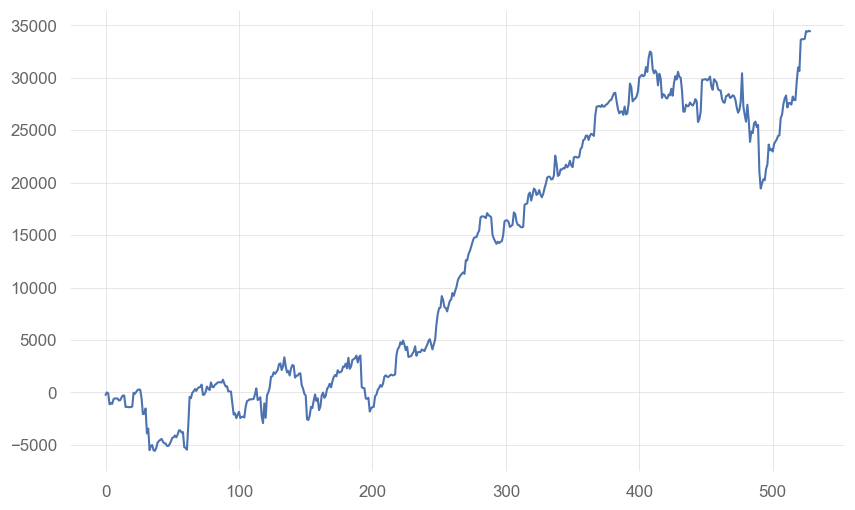

In [101]:
## Simple line plots seem to be using matplotlib
pf_2_bb_custom.trades.records_readable.PnL.cumsum().plot()

In [102]:
pnl_series = pf_2_bb_custom.trades.pnl.to_pd()
pnl_series[pnl_series.notna()]

time
2019-08-29 12:00:00+00:00    -230.535300
2019-08-30 07:00:00+00:00     239.936562
2019-09-04 04:00:00+00:00     -89.537241
2019-09-06 05:00:00+00:00   -1050.625053
2019-09-06 07:15:00+00:00     102.554359
                                ...     
2022-08-25 00:15:00+00:00      57.680801
2022-08-26 12:15:00+00:00     722.141010
2022-08-26 13:45:00+00:00     -53.734046
2022-08-26 14:15:00+00:00      84.030901
2022-08-26 16:45:00+00:00     -48.650096
Length: 529, dtype: float64

### Creating Stacked SubPlots on Sliced Data

In [103]:
def plot_strategy(slice_lower : str, slice_upper: str, df : pd.DataFrame , rsi : pd.Series,
                         bb_price : vbt.indicators.factory, bb_rsi : vbt.indicators.factory, 
                         entries: pd.Series, exits: pd.Series, 
                         long_trades: pd.DataFrame, short_trades: pd.DataFrame,
                         pf: vbt.portfolio.base.Portfolio,
                         show_legend : bool = True):
    """Creates a stacked indicator plot for the 2BB strategy.
    Parameters
    ===========
    slice_lower : str, start date of dataframe slice in yyyy.mm.dd format
    slice_upper : str, start date of dataframe slice in yyyy.mm.dd format
    df          : pd.DataFrame, containing the OHLCV data
    rsi         : pd.Series, rsi indicator time series in same freq as df
    bb_price    : vbt.indicators.factory.talib('BBANDS'), computed on df['close'] price
    bb_rsi      : vbt.indicators.factory.talib('BBANDS') computer on RSI
    entries     : pd.Series, time series data of long entries
    exits       : pd.Series, time series data of long exits
    long_trades : pd.DataFrame, long_trades from `pf.trades.records_readable`
    short_trades: pd.DataFrame, short_trades from `pf.trades.records_readable`
    show_legend : bool, switch to show or completely hide the legend box on the plot
    
    Returns
    =======
    fig         : plotly figure object
    """
    kwargs1 = {"title_text" : "H4 OHLCV with BBands on Price and RSI", 
               "title_font_size" : 18,
               "height" : 960,
               "legend" : dict(yanchor="top",y=0.99, xanchor="right",x= 0.1)}
    fig = vbt.make_subplots(rows=2,cols=1, shared_xaxes=True, vertical_spacing=0.1)
    ## Filter Data according to date slice
    df_slice = df[["Open", "High", "Low", "Close"]][slice_lower : slice_upper]
    bb_price = bb_price[slice_lower : slice_upper]
    rsi = rsi[slice_lower : slice_upper]
    bb_rsi = bb_rsi[slice_lower : slice_upper]
    entries = entries[slice_lower : slice_upper]
    exits = exits[slice_lower : slice_upper]
    long_trades = long_trades[slice_lower : slice_upper].reset_index()
    short_trades = short_trades[slice_lower : slice_upper].reset_index()

    ## Retrieve Filled entry and exit prices
    entry_prices = pd.concat([long_trades[['Entry Index', 'Avg Entry Price']], short_trades[['Entry Index', 'Avg Entry Price']]]).sort_values('Entry Index').set_index('Entry Index')
    exit_prices = pd.concat([long_trades[['Exit Index', 'Avg Exit Price']], short_trades[['Exit Index', 'Avg Exit Price']]]).sort_values('Exit Index').set_index('Exit Index')
    # entry_prices.index.names = ['time']
    # exit_prices.index.names = ['time']
    # entry_prices.name = 'Entries'
    # exit_prices.name = 'Exits'
    
    ## Retrieve datetime index of rows where price data is NULL
    # retrieve the dates that are in the original datset
    dt_obs = df_slice.index.to_list()
    # Drop rows with missing values
    dt_obs_dropped = df_slice['Close'].dropna().index.to_list()
    # store  dates with missing values
    dt_breaks = [d for d in dt_obs if d not in dt_obs_dropped]

    ## Plot Figures
    df_slice.vbt.ohlcv.plot(add_trace_kwargs=dict(row=1, col=1),  fig=fig, **kwargs1) ## Without Range Slider
    rsi.rename("RSI").vbt.plot(add_trace_kwargs=dict(row=2, col=1), trace_kwargs = dict(connectgaps=True), fig=fig, **kwargs1 ) 

    bb_dotted_line = dict(color="white",width=1, dash="dot")
    bb_price.plot(add_trace_kwargs=dict(row=1, col=1),fig=fig, **kwargs1,
                lowerband_trace_kwargs=dict(fill=None, name = 'BB_Price_Lower', connectgaps=True, line = bb_dotted_line), 
                upperband_trace_kwargs=dict(fill=None, name = 'BB_Price_Upper', connectgaps=True, line = bb_dotted_line),
                middleband_trace_kwargs=dict(fill=None, name = 'BB_Price_Middle', connectgaps=True) )

    bb_rsi.plot(add_trace_kwargs=dict(row=2, col=1),limits=(25, 75),fig=fig,
                lowerband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Lower', connectgaps=True,line = bb_dotted_line), 
                upperband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Upper', connectgaps=True,line = bb_dotted_line),
                middleband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Middle', connectgaps=True, visible = False))
    
    pf[slice_lower:slice_upper].plot_trade_signals(add_trace_kwargs=dict(row=1, col=1),fig=fig,
                                                   plot_close=False, plot_positions="lines")

    ## Add Marker style for Long Entries and Long Exits
    # long_entry_marker_style = dict(color="limegreen",symbol="triangle-up",size = 14)
    # long_exit_marker_style_zero = dict(color="red", symbol="square-open", size = 14)
    # long_exit_marker_style_profit = dict(color="red", symbol="triangle-down", size = 14)
    # long_exit_marker_style_loss = dict(color="red", symbol="circle-open-dot", size = 14)

    pf.trades.direction_long[slice_lower : slice_upper].plot(
                                        add_trace_kwargs=dict(row=1, col=1),fig=fig,
                                        plot_close = False,
                                        plot_markers = False,
                                        # entry_trace_kwargs = dict(name = "Long Entries", marker = long_entry_marker_style),
                                        # exit_trace_kwargs = dict(name = "Long Exits BreakEven", marker = long_exit_marker_style_zero),
                                        # exit_profit_trace_kwargs = dict(name = "Long Exits Profit", marker = long_exit_marker_style_profit),
                                        # exit_loss_trace_kwargs = dict(name = "Long Exits Loss", marker = long_exit_marker_style_loss),
                                        )
                                        
    ## Add Marker Style for Short Entries and Short Exits
    # shot_entry_marker_style = dict(color="limegreen",symbol="triangle-down",size = 14)
    # short_exit_marker_style_zero = dict(color="red", symbol="square-open", size = 14)
    # short_exit_marker_style_profit = dict(color="red", symbol="triangle-up", size = 14)
    # short_exit_marker_style_loss = dict(color="red", symbol="circle-open-dot", size = 14)

    pf.trades.direction_short[slice_lower : slice_upper].plot(
                                            add_trace_kwargs=dict(row=1, col=1),fig=fig,
                                            plot_close = False,
                                            plot_markers = False,
                                            # entry_trace_kwargs = dict(name = "Short Entries", marker = shot_entry_marker_style),
                                            # exit_trace_kwargs = dict(name = "Short Exits BreakEven", marker = short_exit_marker_style_zero),
                                            # exit_profit_trace_kwargs = dict(name = "Short Exits Profit", marker = short_exit_marker_style_profit),
                                            # exit_loss_trace_kwargs = dict(name = "Short Exits Loss", marker = short_exit_marker_style_loss),
                                            )

    ## Add Entries and Long Exits on Price
    # entries.vbt.signals.plot_as_entries(df_slice['Close'], fig=fig,
    #                                     trace_kwargs=dict(marker=dict(color="limegreen", size = 12), 
    #                                                       name="Entries")
    #                                         )
    # exits.vbt.signals.plot_as_exits(df_slice['Close'], fig = fig,
    #                                     trace_kwargs=dict(marker=dict(color="red", size = 12), 
    #                                                     name="Exits") 
    #                                     )

    ## Add Entries and Long Exits on RSI in lower subplot
    # entries.vbt.signals.plot_as_entries(rsi, fig = fig,
    #                                          add_trace_kwargs=dict(row=2, col=1),
    #                                          trace_kwargs=dict(marker=dict(color="limegreen"),showlegend = False))  

    # exits.vbt.signals.plot_as_exits(rsi, fig = fig,showlegend = False,
    #                                      add_trace_kwargs=dict(row=2, col=1),
    #                                      trace_kwargs=dict(marker=dict(color="red"),showlegend = False))

    ## Dotted Lines for Long Trades
    # x_axis_long_entries = long_trades['Entry Index'].map(lambda x : x.replace(microsecond=0))
    # y_axis_long_entries = long_trades['Avg Entry Price'].values
    # x_axis_long_exits = long_trades['Exit Index'].map(lambda x : x.replace(microsecond=0))
    # y_axis_long_exits = long_trades['Avg Exit Price'].values

    # for entry_time, entry_price, exit_time, exit_price in zip(x_axis_long_entries, y_axis_long_entries, 
    #                                                             x_axis_long_exits, y_axis_long_exits):
    #     fig.add_shape(type="line",x0=entry_time, y0=entry_price, 
    #                                 x1=exit_time, y1=exit_price,
    #                                 line=dict(color="aquamarine",width=2,dash="dot"))

    ## Dotted Lines for Short Trades
    # x_axis_short_entries = short_trades['Entry Index'].map(lambda x : x.replace(microsecond=0))
    # y_axis_short_entries = short_trades['Avg Entry Price'].values
    # x_axis_short_exits = short_trades['Exit Index'].map(lambda x : x.replace(microsecond=0))
    # y_axis_short_exits = short_trades['Avg Exit Price'].values

    # for entry_time, entry_price, exit_time, exit_price in zip(x_axis_short_entries, y_axis_short_entries, 
    #                                                             x_axis_short_exits, y_axis_short_exits):
    #     fig.add_shape(type="line",x0=entry_time, y0=entry_price, 
    #                                 x1=exit_time, y1=exit_price,
    #                                 line=dict(color="magenta",width=2, dash="dot")) 

    fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])
    fig.layout.showlegend = show_legend  
    # fig.write_html(f"2BB_Strategy_{slice_lower}_to_{slice_upper}.html")
    
    return fig

In [104]:
pf_2_bb_custom.trade_history

,Order Id,Column,Signal Index,Creation Index,Fill Index,Side,Type,Stop Type,Size,Price,Fees,PnL,Return,Direction,Status,Entry Trade Id,Exit Trade Id,Position Id
0,0,0,2019-08-28 13:45:00+00:00,2019-08-28 13:45:00+00:00,2019-08-28 13:45:00+00:00,Buy,Market,None,81750.106275,1.223240,0.0,-230.535300,-0.002305,Long,Closed,0,-1,0
2,1,0,2019-08-29 12:00:00+00:00,2019-08-29 12:00:00+00:00,2019-08-29 12:00:00+00:00,Sell,Market,None,81750.106275,1.220420,0.0,-230.535300,-0.002305,Long,Closed,-1,0,0
1,1,0,2019-08-29 12:00:00+00:00,2019-08-29 12:00:00+00:00,2019-08-29 12:00:00+00:00,Sell,Market,None,81750.106275,1.220420,0.0,239.936562,0.002405,Short,Closed,1,-1,1
4,2,0,2019-08-30 07:00:00+00:00,2019-08-30 07:00:00+00:00,2019-08-30 07:00:00+00:00,Buy,Market,None,81750.106275,1.217485,0.0,239.936562,0.002405,Short,Closed,-1,1,1
3,2,0,2019-08-30 07:00:00+00:00,2019-08-30 07:00:00+00:00,2019-08-30 07:00:00+00:00,Buy,Market,None,82144.257434,1.217485,0.0,-89.537241,-0.000895,Long,Closed,2,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,526,0,2022-08-26 12:15:00+00:00,2022-08-26 12:15:00+00:00,2022-08-26 12:15:00+00:00,Buy,Market,None,114327.756678,1.175985,0.0,-53.734046,-0.000400,Long,Closed,526,-1,526
1054,527,0,2022-08-26 13:45:00+00:00,2022-08-26 13:45:00+00:00,2022-08-26 13:45:00+00:00,Sell,Market,None,114327.756678,1.175515,0.0,-53.734046,-0.000400,Long,Closed,-1,526,526
1053,527,0,2022-08-26 13:45:00+00:00,2022-08-26 13:45:00+00:00,2022-08-26 13:45:00+00:00,Sell,Market,None,114327.756678,1.175515,0.0,84.030901,0.000625,Short,Closed,527,-1,527
1056,528,0,2022-08-26 14:15:00+00:00,2022-08-26 14:15:00+00:00,2022-08-26 14:15:00+00:00,Buy,Market,None,114327.756678,1.174780,0.0,84.030901,0.000625,Short,Closed,-1,527,527


In [105]:
df_trades = pf_2_bb_custom.trades.records_readable
df_trades

,Exit Trade Id,Column,Size,Entry Order Id,Entry Index,Avg Entry Price,Entry Fees,Exit Order Id,Exit Index,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,81750.106275,0,2019-08-28 13:45:00+00:00,1.223240,0.0,1,2019-08-29 12:00:00+00:00,1.220420,0.0,-230.535300,-0.002305,Long,Closed,0
1,1,0,81750.106275,1,2019-08-29 12:00:00+00:00,1.220420,0.0,2,2019-08-30 07:00:00+00:00,1.217485,0.0,239.936562,0.002405,Short,Closed,1
2,2,0,82144.257434,2,2019-08-30 07:00:00+00:00,1.217485,0.0,3,2019-09-04 04:00:00+00:00,1.216395,0.0,-89.537241,-0.000895,Long,Closed,2
3,3,0,82144.257434,3,2019-09-04 04:00:00+00:00,1.216395,0.0,4,2019-09-06 05:00:00+00:00,1.229185,0.0,-1050.625053,-0.010515,Short,Closed,3
4,4,0,80434.791320,4,2019-09-06 05:00:00+00:00,1.229185,0.0,5,2019-09-06 07:15:00+00:00,1.230460,0.0,102.554359,0.001037,Long,Closed,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,524,0,113099.610043,524,2022-08-24 05:00:00+00:00,1.181860,0.0,525,2022-08-25 00:15:00+00:00,1.182370,0.0,57.680801,0.000432,Long,Closed,524
525,525,0,113099.610043,525,2022-08-25 00:15:00+00:00,1.182370,0.0,526,2022-08-26 12:15:00+00:00,1.175985,0.0,722.141010,0.005400,Short,Closed,525
526,526,0,114327.756678,526,2022-08-26 12:15:00+00:00,1.175985,0.0,527,2022-08-26 13:45:00+00:00,1.175515,0.0,-53.734046,-0.000400,Long,Closed,526
527,527,0,114327.756678,527,2022-08-26 13:45:00+00:00,1.175515,0.0,528,2022-08-26 14:15:00+00:00,1.174780,0.0,84.030901,0.000625,Short,Closed,527


In [106]:
long_trades = df_trades[['Position Id','Entry Index', 'Avg Entry Price', 'Exit Index', 'Avg Exit Price' , 'Direction' ,'PnL', 'Return']][df_trades['Direction'] == "Long"].set_index('Entry Index')#.squeeze()
short_trades = df_trades[['Position Id','Entry Index', 'Avg Entry Price', 'Exit Index', 'Avg Exit Price', 'Direction' ,'PnL', 'Return']][df_trades['Direction'] == "Short"].set_index('Entry Index')#.squeeze()

In [107]:
len(long_trades), len(short_trades)

(265, 264)

In [108]:
slice_lower = '2019.09.01'
slice_higher = '2020.01.31'

In [109]:
## from VBT Pro - develop branch
# pf_2_bb_custom.plot_trade_signals()

In [110]:
## from VBT Pro - develop branch
pf_2_bb_custom[slice_lower:slice_higher].plot_trade_signals(plot_close=False, plot_positions="lines").show()

In [111]:
## If you don't add .show() - white border will be present
pf_2_bb_custom.trades[slice_lower : slice_higher].plot(plot_close = False)

FigureWidget({
    'data': [{'customdata': array([['3', '3', '3', ..., 1.216395, 0.0, 'Short'],
              …

API Documentation:
```python
Trades.plot(
    column=None,
    plot_ohlc=True,
    plot_close=True,
    plot_markers=True,
    plot_zones=True,
    ohlc_type=None,
    ohlc_trace_kwargs=None,
    close_trace_kwargs=None,
    entry_trace_kwargs=None,
    exit_trace_kwargs=None,
    exit_profit_trace_kwargs=None,
    exit_loss_trace_kwargs=None,
    active_trace_kwargs=None,
    profit_shape_kwargs=None,
    loss_shape_kwargs=None,
    add_trace_kwargs=None,
    xref='x',
    yref='y',
    fig=None,
    **layout_kwargs
)
```

In [112]:
## Add Marker Style for Long Entries and Long Exits
long_entry_marker_style = dict(color="limegreen",symbol="triangle-up",size = 12)
long_exit_marker_style_zero = dict(color="red", symbol="square-open", size = 12)
long_exit_marker_style_profit = dict(color="red", symbol="triangle-down", size = 12)
long_exit_marker_style_loss = dict(color="red", symbol="circle-open-dot", size = 12)

In [113]:
## Long Entries and Long Exits - entry_trace_kwargs and exit_trace_kwargs NOT WORKING
pf_2_bb_custom.trades.direction_long[slice_lower : slice_higher].plot(
                                        plot_close = False,
                                        entry_trace_kwargs = dict(name = "Long Entries", marker = long_entry_marker_style),
                                        exit_trace_kwargs = dict(name = "Long Exits BreakEven", marker = long_exit_marker_style_zero),
                                        exit_profit_trace_kwargs = dict(name = "Long Exits Profit", marker = long_exit_marker_style_profit),
                                        exit_loss_trace_kwargs = dict(name = "Long Exits Loss", marker = long_exit_marker_style_loss),
                                                        ).show()

In [114]:
## Add Marker Style for Short Entries and Short Exits
shot_entry_marker_style = dict(color="limegreen",symbol="triangle-down",size = 12)
short_exit_marker_style_zero = dict(color="red", symbol="square-open", size = 12)
short_exit_marker_style_profit = dict(color="red", symbol="triangle-up", size = 12)
short_exit_marker_style_loss = dict(color="red", symbol="circle-open-dot", size = 12)

In [115]:
pf_2_bb_custom.trades.direction_short[slice_lower : slice_higher].plot(
    plot_close = False,
    # plot_zones = False,
    # exit_profit_trace_kwargs = dict(visible = False),
    # exit_loss_trace_kwargs = dict(visible = False),
    entry_trace_kwargs = dict(name = "Short Entries", marker = shot_entry_marker_style),
    exit_trace_kwargs = dict(name = "Short Exits BreakEven", marker = short_exit_marker_style_zero),
    exit_profit_trace_kwargs = dict(name = "Short Exits Profit", marker = short_exit_marker_style_profit),
    exit_loss_trace_kwargs = dict(name = "Short Exits Loss", marker = short_exit_marker_style_loss),
).show()

In [116]:
slice_lower = '2019.09.01'
slice_higher = '2019.12.31'

fig = plot_strategy(slice_lower, slice_higher, h4_df, h4_rsi, 
                           h4_bbands, h4_bbands_rsi, 
                           clean_h4_entries, clean_h4_exits, 
                           long_trades, short_trades,
                           pf_2_bb_custom,
                           show_legend = True)

fig.show()

### Save final dataframe with consolidated signals and `P&L`

In [117]:
# mtf_df['cleaned_signal'] = signal
mtf_df["pnl"] = pnl_series
mtf_df

,m15_close,m15_rsi,m15_bband_price_upper,m15_bband_price_middle,m15_bband_price_lower,m15_bband_rsi_upper,m15_bband_rsi_middle,m15_bband_rsi_lower,m30_close,m30_rsi,...,h4_bband_price_upper,h4_bband_price_middle,h4_bband_price_lower,h4_bband_rsi_upper,h4_bband_rsi_middle,h4_bband_rsi_lower,entry,exit,signal,pnl
time,,,,,,,,,,,,,,,,,,,,,
2019-08-27 00:00:00+00:00,1.221165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,NaN
2019-08-27 00:15:00+00:00,1.221705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221705,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,NaN
2019-08-27 00:30:00+00:00,1.221790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221705,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,NaN
2019-08-27 00:45:00+00:00,1.221735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221735,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,NaN
2019-08-27 01:00:00+00:00,1.221890,NaN,1.222165,1.221657,1.221149,NaN,NaN,NaN,1.221735,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-26 15:45:00+00:00,1.173765,32.831305,1.174692,1.174085,1.173478,34.856820,33.463077,32.069334,1.173765,32.952819,...,1.185437,1.17896,1.172483,47.617494,42.127199,36.636905,False,False,0,NaN
2022-08-26 16:00:00+00:00,1.173510,32.175416,1.174568,1.173909,1.173250,34.593092,33.073149,31.553206,1.173765,32.952819,...,1.185437,1.17896,1.172483,47.617494,42.127199,36.636905,False,False,0,NaN
2022-08-26 16:15:00+00:00,1.174110,35.365534,1.174339,1.173847,1.173355,35.571314,33.293702,31.016089,1.174110,34.276540,...,1.185437,1.17896,1.172483,47.617494,42.127199,36.636905,False,False,0,NaN


In [118]:
# mtf_df.to_csv("2BB_Final_Simulation.csv", index = False)

In [119]:
mtf_df.columns

Index(['m15_close', 'm15_rsi', 'm15_bband_price_upper',
       'm15_bband_price_middle', 'm15_bband_price_lower',
       'm15_bband_rsi_upper', 'm15_bband_rsi_middle', 'm15_bband_rsi_lower',
       'm30_close', 'm30_rsi', 'm30_bband_price_upper',
       'm30_bband_price_middle', 'm30_bband_price_lower',
       'm30_bband_rsi_upper', 'm30_bband_rsi_middle', 'm30_bband_rsi_lower',
       'h1_open', 'h1_high', 'h1_low', 'h1_close', 'h1_rsi',
       'h1_bband_price_upper', 'h1_bband_price_middle', 'h1_bband_price_lower',
       'h1_bband_rsi_upper', 'h1_bband_rsi_middle', 'h1_bband_rsi_lower',
       'h4_open', 'h4_high', 'h4_low', 'h4_close', 'h4_rsi',
       'h4_bband_price_upper', 'h4_bband_price_middle', 'h4_bband_price_lower',
       'h4_bband_rsi_upper', 'h4_bband_rsi_middle', 'h4_bband_rsi_lower',
       'entry', 'exit', 'signal', 'pnl'],
      dtype='object')